In [12]:
#pip install captcha
#pip install -U scikit-learn
#pip install tensorflow
#pip install keras

Note: you may need to restart the kernel to use updated packages.


## Generate CAPTCHA Characters for Training

### Prepare Directories

In [1]:
import os
import shutil

# Create the following directories and ensure that they are empty
for directory in list([
    "captcha_characters",
    "captcha_characters_no_noise",
    "captcha_characters_segmented",
    "captcha_characters_training",
    "captcha_characters_training_dataset"]):
    if os.path.exists(directory):
        shutil.rmtree(directory)
    os.makedirs(directory, exist_ok=True)

### Create CAPTCHAS For Every Letter & Digit

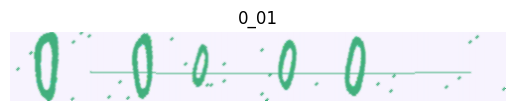

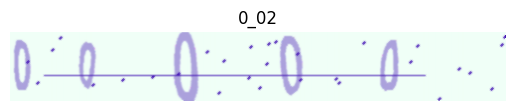

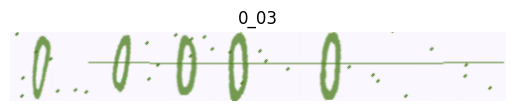

In [2]:
import os
import string
import matplotlib.pyplot as plt
from captcha.image import ImageCaptcha

# Parameters
num_of_loops = 105

for loop in range(num_of_loops):
    # Parameters
    string_length = 5
    image_width = 100 * string_length
    image_height = 70
    output_dir = 'captcha_characters'
    iteration_str = f"{loop+1:02}"

    for char in string.ascii_uppercase + string.digits:
        # Generate a CAPTCHA
        captcha_text = f"{char}  " * string_length
        captcha = ImageCaptcha(width=image_width, height=image_height)
        captcha_image = captcha.generate_image(captcha_text)
        captcha_text = captcha_text.replace('  ', '')

        # Save CAPTCHA as PNG
        filename = os.path.join(output_dir, f'{char}_{iteration_str}.png')
        captcha_image.save(filename)

# Plot
num_images = 3
png_files = sorted([file for file in os.listdir(output_dir) if file.endswith('.png')])[:num_images]

for png_file in png_files:
    image_path = os.path.join(output_dir, png_file)
    image = plt.imread(image_path)
    
    plt.imshow(image, cmap='gray')
    plt.title(png_file[:-4])
    plt.axis('off')
    plt.show()

### Remove Noise

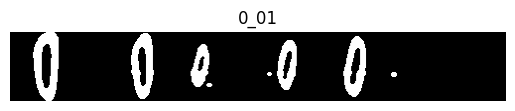

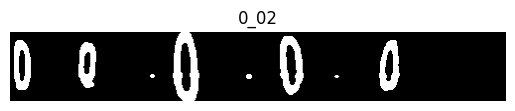

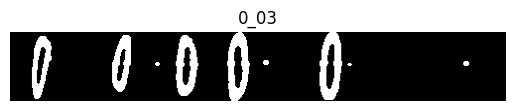

In [3]:
import os
import cv2
import numpy as np

# Parameters
input_dir = "captcha_characters"
output_dir = "captcha_characters_no_noise"

for filename in os.listdir(input_dir):
    if filename.endswith(".png"):
        # Convert CAPTCHA to greyscale then make black or white with a threshold
        image = cv2.imread(os.path.join(input_dir, filename), cv2.IMREAD_GRAYSCALE)
        _, binarized = cv2.threshold(image, 230, 255, cv2.THRESH_BINARY_INV)
        
        # Remove pixels with erosion to weaken noise
        kernel = np.ones((3, 3), np.uint8)
        eroded = cv2.erode(binarized, kernel, iterations=1)
        
        # Remove pixels with a median filter to weaken vertical and horizontal lines
        median_filtered = cv2.medianBlur(eroded, 3)
        horizontal_kernel = np.ones((1, 5), np.uint8)
        horizontal_filtered = cv2.morphologyEx(median_filtered, cv2.MORPH_CLOSE, horizontal_kernel)
        
        # Add pixels with dilation to thicken letters and digits
        dilation_kernel = np.ones((3, 3), np.uint8)
        dilated = cv2.dilate(horizontal_filtered, dilation_kernel, iterations=1)
        
        # Remove pixels with a median filter again for good measure
        result = cv2.medianBlur(dilated, 3)
        
        # Save processed CAPTCHA as PNG
        output_path = os.path.join(output_dir, filename)
        cv2.imwrite(output_path, result)
        
# Plot
num_images = 3
png_files = sorted([file for file in os.listdir(output_dir) if file.endswith('.png')])[:num_images]

for png_file in png_files:
    image_path = os.path.join(output_dir, png_file)
    image = plt.imread(image_path)
    
    plt.imshow(image, cmap='gray')
    plt.title(png_file[:-4])
    plt.axis('off')
    plt.show()


### Segment Characters Part 1

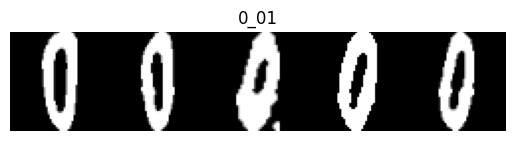

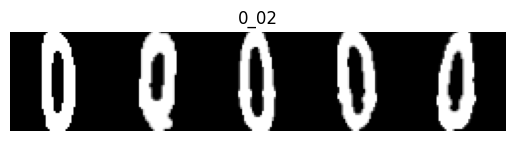

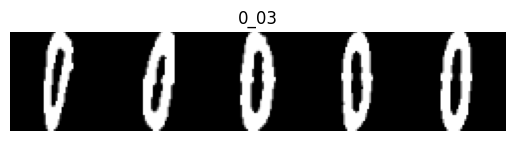

In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Parameters
string_length = 5
input_dir = "captcha_characters_no_noise"
output_dir = "captcha_characters_segmented"

for filename in os.listdir(input_dir):
    if filename.endswith(".png"):
        # Read CAPTCHA as grayscale
        image = cv2.imread(os.path.join(input_dir, filename), cv2.IMREAD_GRAYSCALE)
        
        # Find contours and filter any small contours (noise)
        contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        filtered_contours = [contour for contour in contours if cv2.contourArea(contour) > 100]
        
        # Sort contours from left to right and only keep the specified number
        filtered_contours = sorted(filtered_contours, key=lambda contour: cv2.boundingRect(contour)[0])
        num_contours = min(len(filtered_contours), string_length)
        
        # Initialize a black background for the output
        segmented_canvas = np.zeros((50, 50 * num_contours), dtype=np.uint8)
        
        for i, contour in enumerate(filtered_contours[:num_contours]):
            x, y, w, h = cv2.boundingRect(contour)
            
            # Calculate the aspect ratio
            aspect_ratio = w / h
            
            # Calculate new width and height to maintain aspect ratio within 50x50 canvas
            new_width = min(50, int(aspect_ratio * 50))
            new_height = min(50, int(50 / aspect_ratio))
            
            # Resize the character to the calculated size and place on the black background
            character = image[y:y+h, x:x+w]
            resized_character = cv2.resize(character, (new_width, new_height))
            x_offset = (50 - new_width) // 2
            y_offset = (50 - new_height) // 2
            segmented_canvas[y_offset:y_offset+new_height, i * 50 + x_offset : i * 50 + x_offset + new_width] = resized_character
        
        # Save processed CAPTCHA as PNG
        output_path = os.path.join(output_dir, filename)
        cv2.imwrite(output_path, segmented_canvas)
        
# Plot
num_images = 3
png_files = sorted([file for file in os.listdir(output_dir) if file.endswith('.png')])[:num_images]

for png_file in png_files:
    image_path = os.path.join(output_dir, png_file)
    image = plt.imread(image_path)
    
    plt.imshow(image, cmap='gray')
    plt.title(png_file[:-4])
    plt.axis('off')
    plt.show()


### Segment Characters Part 2

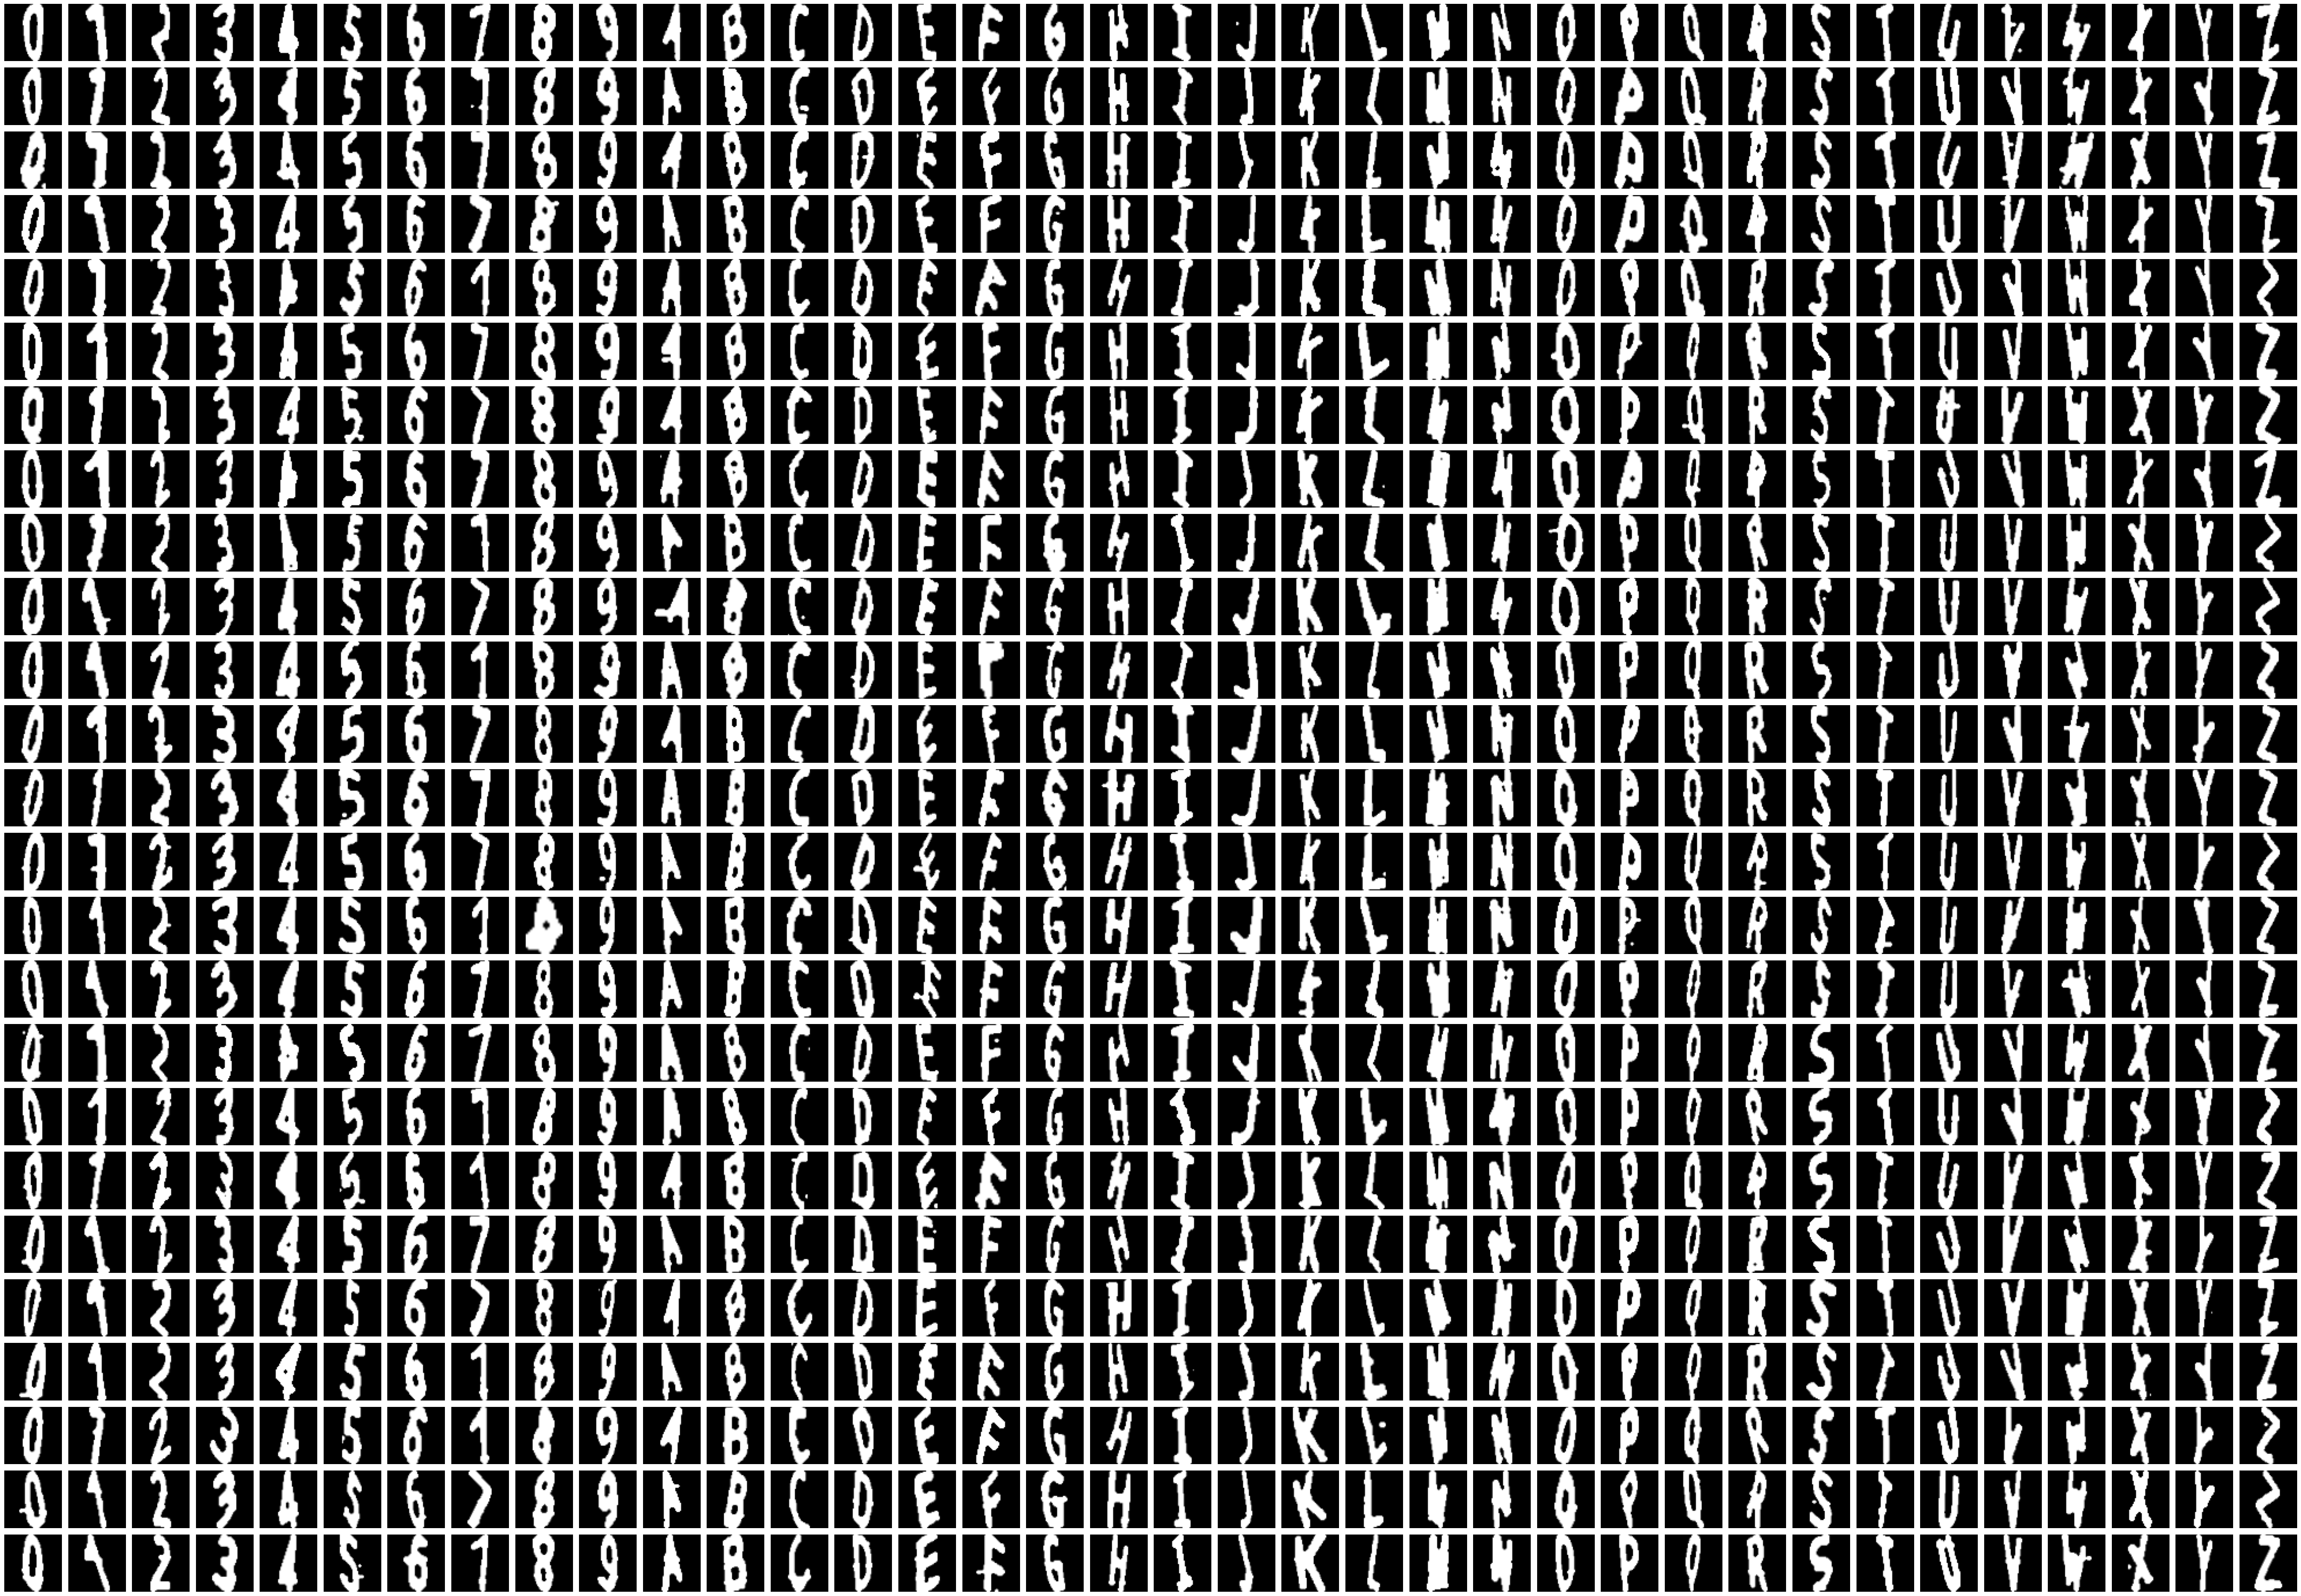

In [5]:
import os
import cv2
import matplotlib.pyplot as plt

# Parameters
input_dir = "captcha_characters_segmented"
output_dir = "captcha_characters_training"
max_samples_per_character = 500

# Dictionary for iteration
character_iteration = {}

for filename in os.listdir(input_dir):
    if filename.endswith(".png"):
        # Split image into 50x50 segments for each character
        image = cv2.imread(os.path.join(input_dir, filename), cv2.IMREAD_GRAYSCALE)
        num_sub_images = image.shape[1] // 50
        first_character = filename[0]
        
        # Get character iteration
        if first_character not in character_iteration:
            character_iteration[first_character] = 1
        
        for i in range(num_sub_images):
            sub_image = image[:, i * 50 : (i + 1) * 50]
            
            # Format iteration with a leading zero
            iteration_str = f"{character_iteration[first_character]:02}"
            
            # Save 50x50 segment as a PNG
            sub_image_filename = f"{first_character}_{iteration_str}.png"
            sub_image_path = os.path.join(output_dir, sub_image_filename)
            cv2.imwrite(sub_image_path, sub_image)
            character_iteration[first_character] += 1
            
            # Break the loop if there are enough samples for a character
            if character_iteration[first_character] >= max_samples_per_character:
                break

# Plot
num_rows = 25
character_images = {}

for filename in os.listdir(output_dir):
    if filename.endswith(".png"):
        character = filename[0]
        image = cv2.imread(os.path.join(output_dir, filename), cv2.IMREAD_GRAYSCALE)
        
        if character not in character_images:
            character_images[character] = [image]
        else:
            character_images[character].append(image)

num_columns = len(character_images)
fig, axes = plt.subplots(num_rows, num_columns, figsize=(num_columns * 1.5, num_rows * 1.5))

for col_idx, (character, images) in enumerate(character_images.items()):
    for row_idx, image in enumerate(images[:num_rows]):
        ax = axes[row_idx, col_idx]
        ax.imshow(image, cmap='gray')
        ax.axis('off')

plt.tight_layout()
plt.show()

### Create Dataset

In [6]:
import os
import cv2

# Parameters
input_dir = "captcha_characters_training"
output_dir = "captcha_characters_training_dataset"

# Process each sub-image
for filename in os.listdir(input_dir):
    if filename.endswith(".png"):
        # Read image
        image = cv2.imread(os.path.join(input_dir, filename), cv2.IMREAD_GRAYSCALE)
        
        # Get the label (character) from the filename
        label = filename[0]
        
        # Create a subfolder for the label if it doesn't exist
        label_dir = os.path.join(output_dir, label)
        os.makedirs(label_dir, exist_ok=True)
        
        # Save the image with its original filename in the label subfolder
        output_path = os.path.join(label_dir, filename)
        cv2.imwrite(output_path, image)

### Train Model

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Preprocess data
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_data = data_gen.flow_from_directory('captcha_characters_training_dataset', target_size=(50, 50), batch_size=32, subset='training', color_mode='grayscale')
valid_data = data_gen.flow_from_directory('captcha_characters_training_dataset', target_size=(50, 50), batch_size=32, subset='validation', color_mode='grayscale')

# CNN
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(50, 50, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(36, activation='softmax')
])

# Compile model & train
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_data, epochs=10, validation_data=valid_data)

Found 14542 images belonging to 36 classes.
Found 3600 images belonging to 36 classes.
Epoch 1/10
455/455 [==============================] - 93s 202ms/step - loss: 0.7513 - accuracy: 0.7871 - val_loss: 0.2619 - val_accuracy: 0.9203
Epoch 2/10
455/455 [==============================] - 21s 47ms/step - loss: 0.1786 - accuracy: 0.9392 - val_loss: 0.2388 - val_accuracy: 0.9283
Epoch 3/10
455/455 [==============================] - 23s 51ms/step - loss: 0.1085 - accuracy: 0.9592 - val_loss: 0.2028 - val_accuracy: 0.9400
Epoch 4/10
455/455 [==============================] - 26s 56ms/step - loss: 0.0802 - accuracy: 0.9683 - val_loss: 0.1963 - val_accuracy: 0.9411
Epoch 5/10
455/455 [==============================] - 27s 59ms/step - loss: 0.0612 - accuracy: 0.9757 - val_loss: 0.2449 - val_accuracy: 0.9364
Epoch 6/10
455/455 [==============================] - 28s 61ms/step - loss: 0.0487 - accuracy: 0.9802 - val_loss: 0.2104 - val_accuracy: 0.9442
Epoch 7/10
455/455 [============================

### Save Model

In [9]:
# Save the model as an h5 file
model.save('captcha_character_model.h5')
print("Model saved as captcha_character_model.h5")

Model saved as captcha_character_model.h5
